# 多项式回归、数据集划分和模型泛化

也就是将原来的线性回归扩展为多项式回归，其实也就是在线性回归上添加了核函数。
也就是将原来线性回归的假设模型：
$$
y=aX+b
$$
扩展为:
$$
y=a_1X^2+a_2X+b
$$

In [1]:
from pylab import *

In [2]:
X = np.random.uniform(-3,3,size=100)
X=X.reshape(1,-1)

In [3]:
X.shape

(1, 100)

In [4]:
y = 0.5 * X**2 +X+2+np.random.normal(0,1,size=100)

In [5]:
y.shape

(1, 100)

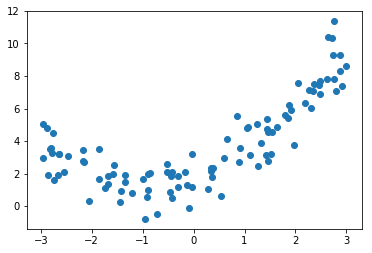

In [6]:
plt.scatter(X,y)
plt.show()

In [7]:
# 线性回归
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
y_prediction = lin_reg.predict(X)

In [9]:
y_prediction.shape

(1, 100)

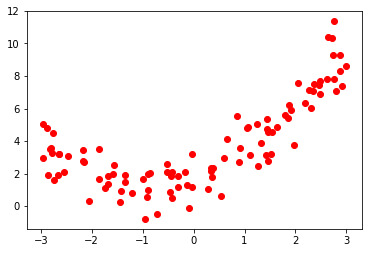

In [10]:
#plt.scatter(X,y)
plt.scatter(X,y_prediction,color='r')
plt.show()

注意：sklearn中的LinearRegression已经集成了多项式回归，所以这里我们就不做线性回归了。多项式回归注意sklearn提供的通用多项式核函数集成方法，主要是两个函数调用：  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
  
在数据预处理阶段由于数据中每一个维度的数据相差太大，需要预先做数据归一化。
from sklearn.preprocessing import StandardScaler

所以就形成了特征应用的基本步骤：  
- 1.可能寻找多项式核函数
- 2.必须使用归一化
- 3.送入分类器训练
  
上述三个步骤可以用一个pipeline封装为符合sklearn调用的管道方式，进行一般性调用

##  过拟合和欠拟合
过拟合指的多项式中的degree太大
欠拟合指的是多项式degree太小，如为0  
测量方式可以通过调用  
from  sklearn.metrics import mean_squared_error  
越小越好

In [11]:
from  sklearn.metrics import mean_squared_error
mean_squared_error(y,y_prediction)

0.0

模型泛化能力的学习曲线  
指的是分别画出训练结果模型在不同训练数据集下在训练集和测试集的预测结果；该结果为两个曲线，横轴为训练集数据，纵轴为mean_squared_error的方差值表示的错误率。测试集错误率总是高于训练集错误率。

如果两个曲线之间距离较远，测试集方差值很大，且远高于训练集，表示模型过拟合；
如果两个曲线之间距离较近，但是两个曲线的方差值较高，表示欠拟合。方差值较低，表示此时训练模型最好

模型泛化指的是训练的结果模型在测试集上得到很好的预测效果。
提高模型的泛化能力就必须将数据集分为训练集和测试集。
但是如果用测试数据来调试模型参数，结果模型最终可能依赖于测试集。因此实际训练时，还需要验证集来调试参数，一般不再将训练集划分为训练集和验证集。而是使用10-folds交叉训练来自动划分训练集为训练集和验证集。验证集用来调整超参数。  
sklearn提供了通用的交叉验证训练调参功能。

# 交叉验证

In [12]:
from sklearn import datasets

In [13]:
digits = datasets.load_digits()
X= digits.data
y = digits.target

### 基本数据集划分

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state=666)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

best_score, best_p, best_k=0,0,0
for k in range(2,11):
    for p in range(1,6):
        knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=k, p=p)
        knn_clf.fit(x_train, y_train)
        score = knn_clf.score(x_test, y_test)
        if score > best_score:
            best_score, best_p, best_k = score, p,k
            
print('best k', best_k)
print('best p', best_p)
print('best score', best_score)
        

best k 3
best p 4
best score 0.986091794159


### 使用交叉验证

In [16]:
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, x_train, y_train)

array([ 0.98895028,  0.97777778,  0.96629213])

In [17]:
best_score, best_p, best_k=0,0,0
for k in range(2,11):
    for p in range(1,6):
        knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=k, p=p)
        scores = cross_val_score(knn_clf, x_train, y_train)  #在训练集的验证集上进行打分，等同于上边的测试集打分，调参
        score = np.mean(scores)
        if score > best_score:
            best_score, best_p, best_k = score, p,k
            
print('best k', best_k)
print('best p', best_p)
print('best score', best_score)

best k 2
best p 2
best score 0.982359987401


In [18]:
# 根据上边找出的最优的k，p建立最优的KNN模型，具有最好的泛化能力
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=2, p=2)
knn_clf.fit(x_train, y_train)
knn_clf.score(x_test, y_test)

0.98052851182197498

# 所有的上述过程，可以通过sklearn提供的网格搜索来实现参数调优

In [19]:
from sklearn.model_selection import GridSearchCV   # cv = cross_validate

param_grid = [
    {
        'weights':['distance'],
        'n_neighbors': [i for i in range(2,11)], #9
        'p': [i for i in range(1,6)]             #5
    }
]

grid_search = GridSearchCV(knn_clf, param_grid, verbose=1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'weights': ['distance'], 'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [20]:
grid_search.best_score_

0.98237476808905377

In [21]:
grid_search.best_params_

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [22]:
best_knn=grid_search.best_estimator_
best_knn.score(x_test, y_test)

0.98052851182197498

结果泛化能力很好，但是训练速度很慢

#  偏差和方差的区别

模型误差 = 偏差 + 方差 + 不可避免的误差  
问题出现的原因：  
偏差：模型假设不对、特征选择不对、欠拟合； 有些算法天生高偏差，所有的参数学习： 如线性回归  
方差：过拟合，模型太复杂； 有些算法天生高方差，所有的非参数学习： 如kNN，决策树  
降低偏差，就会提高方差；  
降低方差，就会提高偏差；  
解决高仿差：
- 降低模型复杂
- 减少数据维度，降噪
- 增加样本
- 使用验证集
- 模型正则化

关于模型正则化，要区分输入数据特征的归一化和模型自身的正则化。  
数据特征归一化通过StandardScaler来解决。  
模型的正则化是通过在loss function中添加正则项来解决。具体来说就是  
预测模型中使用正则化($ L_2 $指正则项$ L_2 $，也可能是$ L_1 $, 指的是$ L_1 $正则)：  
所求不再是$ J(\theta) $,而是 $ J(\theta)+\alpha L_2 $  
其中可以转化为求$ C \cdot J(\theta)+L_2 $  
$ C = \frac{1}{\alpha} $


其中$ L_2 $正则就是岭回归

岭回归的正则化公式：  
$$
目标：使J(\theta) = MSE(y,\hat{y};\theta)+\alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2尽可能小
$$
LASSO回归的正则化公式：  
$$
目标：使J(\theta) = MSE(y,\hat{y};\theta)+\alpha\sum_{i=1}^n |\theta_i|尽可能小
$$

In [23]:
# 岭回归
from sklearn.linear_model import Ridge

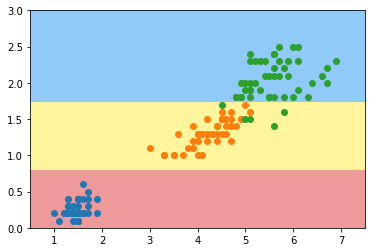

In [26]:
# %load ../pltboundary.py
"""
Created on Wed Jun 13 17:21:17 2018

@author: xhj
"""
from pylab import *
from sklearn import datasets

def plot_decision_boundary(model, axis):
    x0, x1 = np.meshgrid(
            np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1,1),
            np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1,1)
            )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap([ '#EF9A9A', '#FFF59D', '#90CAF9' ])
    plt.contourf(x0, x1, zz, linewidth=5, cmap = custom_cmap)
         

# 添加多项式项目  核函数， pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

def PolynomialLogisticRegression(degree,C=1.0,penalty='l2'):
    return Pipeline([
        ('poly',PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C=C, penalty=penalty))
    ])

from sklearn.linear_model import Ridge
def RidgeRegression(degree,alpha=1):
    return Pipeline([
        ('poly',PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('ridge_reg', Ridge(alpha=alpha))
    ])

from sklearn.linear_model import Lasso
def LassoRegression(degree,alpha=1):
    return Pipeline([
        ('poly',PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('lasso_reg', Lasso(alpha=alpha))
    ])


if __name__ == '__main__':
    iris = datasets.load_iris()
    XXX = iris.data[:, 2:]
    yyy = iris.target
    from sklearn.tree import DecisionTreeClassifier

    dt_clf = DecisionTreeClassifier(max_depth=2, criterion = "entropy")
    dt_clf.fit(XXX,yyy)
    plot_decision_boundary(dt_clf, axis= [0.5, 7.5, 0,3])

    plt.scatter(XXX[yyy==0,0], XXX[yyy==0,1])
    plt.scatter(XXX[yyy==1,0], XXX[yyy==1,1])
    plt.scatter(XXX[yyy==2,0], XXX[yyy==2,1])
    plt.show()
                                  

In [25]:
ridge_reg = RidgeRegression(20,0.0001)
ridge_reg.fit(x_train,y_train)

y1_prediction = ridge_reg.score(x_test)
mean_squared_error(y_test, y1_prediction)

NameError: name 'RidgeRegression' is not defined

In [ ]:
plot_decision_boundary(dt_clf, axis= [-3, 3, 0,6])
plt.scatter(X,y)
plt.show()

#  LASSO 回归
LASSO = least Absolute Shrinkage and Selection Operator Regression  
通常LASSO训练出来的$ \theta $中包含0，表示对应的特征在模型中不采用

LASSO回归的正则化公式：  
$$
目标：使J(\theta) = MSE(y,\hat{y};\theta)+\alpha\sum_{i=1}^n |\theta_i|尽可能小
$$

In [ ]:
lasso_reg = LassoRegression(20,0.01)
lasso_reg.fit(x_train,y_train)

y2_prediction = lasso_reg.score(x_test)
mean_squared_error(y_test, y2_prediction)

#  Ridge和LASSO混合就构成了弹性网络

Ridge   MSE  欧拉距离    平方和  L2范数  
LASSO   MAE  曼哈顿距离  绝对值  L1范数


弹性网络就是求：  

$$
目标：使J(\theta) = MSE(y,\hat{y};\theta)+r\alpha\sum_{i=1}^n |\theta_i|+(1-r)\frac{1}{2}\alpha\sum_{i=1}^n\theta_i^2尽可能小
$$